# 개, 고양이 분류 (partial + centering)
 -  부분 데이터: 훈련용 (개: 1000, 고양이: 1000) / 테스트용 (개: 500 , 고양이: 500)
 - 이미지 센터링 처리

In [1]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-05-24 08:34:11--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.128, 172.253.122.128, 172.253.63.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   137MB/s    in 0.5s    

2022-05-24 08:34:12 (137 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
!unzip cats_and_dogs_filtered.zip > /dev/null

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

 - 데이터 탐색

In [4]:
# 이미지를 축소, 확대 및 센터링해서 이미지를 반환하는 함수
IMAGE_SIZE = 150

(<matplotlib.image.AxesImage at 0x7fdf72cfdc50>, Text(0.5, 1.0, '(287, 431)'))

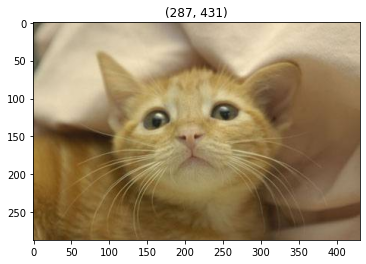

In [5]:
import cv2
fname =  'cats_and_dogs_filtered/train/cats/cat.475.jpg'
img = cv2.imread(fname)[:, :, ::-1]
plt.imshow(img), plt.title(img.shape[:-1])

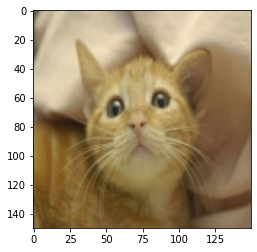

In [6]:
plt.imshow(cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_AREA))

In [7]:
h, w, _ = img.shape
h, w

(287, 431)

In [8]:
if h>w:
    width, height = IMAGE_SIZE, (h * IMAGE_SIZE) // w
else:
    width, height = (w*IMAGE_SIZE) // h, IMAGE_SIZE

In [9]:
# Pillow image --> new_img = np.array(img.resize(width, height))
new_img = cv2.resize(img, dsize=(width,height), interpolation=cv2.INTER_AREA)
new_img.shape

(150, 225, 3)

In [10]:
diff = abs(width - height) // 2

In [11]:
if h > w:
    final_img = new_img[diff:diff+IMAGE_SIZE, :]
else:
    final_img = new_img[:,diff:diff+IMAGE_SIZE]

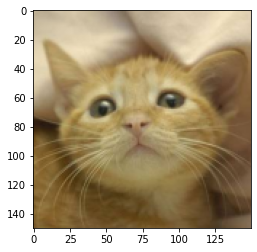

In [12]:
plt.imshow(cv2.resize(final_img, dsize=(150,150), interpolation=cv2.INTER_AREA))

In [13]:
# 센터링 함수
from PIL import Image
def center_img(img, src_format='OpenCV', dst_format = 'OpenCV'):
    if format == 'OpenCV':
        h, w = img.shape[:-1]
    
    else: # Pillow인 경우
        h,w = np.array(img).shape[:-1]

    if h>w:
        width, height = IMAGE_SIZE, (h * IMAGE_SIZE) // w
    
    else:
        width, height = (w*IMAGE_SIZE) // h, IMAGE_SIZE
    
    interpolation = cv2.INTER_AREA if h+w >300 else cv2.INTER_CUBIC
    new_img = cv2.resize(img, dsize=(width,height), interpolation=cv2.INTER_AREA)

    diff = abs(width - height) // 2

    if h > w:
        final_img = new_img[diff:diff+IMAGE_SIZE, :]
    else:
        final_img = new_img[:,diff:diff+IMAGE_SIZE]

    return final_img if dst_format == 'OpenCV' else Image.fromarray(final_img)

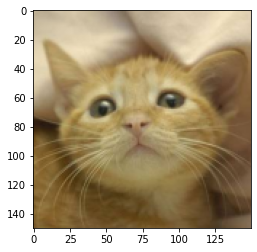

In [14]:
img = cv2.imread(fname)[:, :, ::-1]
plt.imshow(center_img(img));

 - 파일에서 읽어서 센터 이미지로 변환해서 저장

In [15]:
CENTER_DIR = 'cats_and_dogs_centered'
train_dir = f'{CENTER_DIR}/train'
validation_dir = f'{CENTER_DIR}/validation'
train_cats_dir = f'{CENTER_DIR}/train/cats'
train_dogs_dir = f'{CENTER_DIR}/train/dogs'
validation_cats_dir = f'{CENTER_DIR}/validation/cats'
validation_dogs_dir = f'{CENTER_DIR}/validation/dogs'

In [16]:
import os
if not os.path.exists(CENTER_DIR):
    os.mkdir(CENTER_DIR)
for dir in [train_dir,validation_dir,train_cats_dir,train_dogs_dir,validation_cats_dir,validation_dogs_dir]:
    os.mkdir(dir)

In [17]:
old_train_cats_dir = 'cats_and_dogs_filtered/train/cats'
old_train_dogs_dir = 'cats_and_dogs_filtered/train/dogs'
old_validation_cats_dir = 'cats_and_dogs_filtered/validation/cats'
old_validation_dogs_dir = 'cats_and_dogs_filtered/validation/dogs'

In [18]:
# cats_and_dog_filtered -> image 축소, 확대 후 centering -> cats_and_dogs_centered
from glob import glob

for src_dir in [old_train_cats_dir, old_train_dogs_dir, old_validation_cats_dir , old_validation_dogs_dir]:
    dst_dir = src_dir.replace('filtered', 'centered')
    
    for fname in glob(f'{src_dir}/*.jpg'):
        dst_fname = fname.split('/')[-1]
        src_img = cv2.imread(fname)[:, : , ::1]
        dst_img = center_img(src_img, src_format='OpenCV', dst_format='Pillow')
        dst_img.save(f'{dst_dir}/{dst_fname}')

In [19]:
# 파일 이름
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)

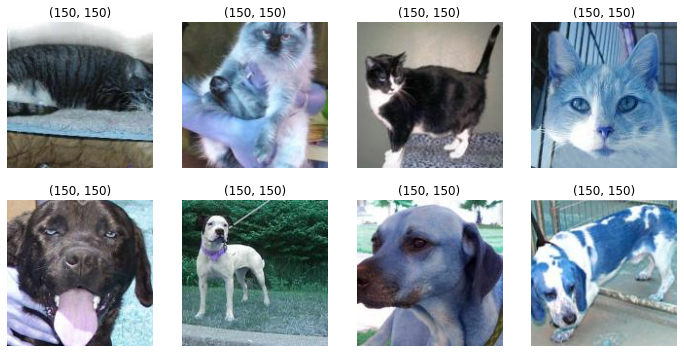

In [20]:
plt.figure(figsize=(12,6))
for i in range(4):
    plt.subplot(2, 4, i+1)
    cat = cv2.imread(os.path.join(train_cats_dir, train_cats_fnames[i]))[:,:,::-1]
    plt.imshow(cat), plt.axis('off'), plt.title(cat.shape[:-1])
    plt.subplot(2, 4, i+5)
    dog = cv2.imread(os.path.join(train_dogs_dir, train_dogs_fnames[i]))[:,:,::-1]
    plt.imshow(dog), plt.axis('off'), plt.title(dog.shape[:-1])
plt.show()

In [21]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [22]:
model = Sequential([Conv2D(16, (3,3), input_shape=(150,150,3), activation='relu'),
                    MaxPooling2D(),
                    Conv2D(32, (3,3), activation='relu'),
                    MaxPooling2D(),
                    Conv2D(64, (3,3), activation='relu'),
                    MaxPooling2D(),
                    Flatten(),
                    Dense(512, activation='relu'),
                    # Dropout(0.25),
                    Dense(1, activation='sigmoid')
                    ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [23]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001, decay=1e-8), loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
model_path = 'best_cats_and_dogs_v2.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, vervose=1)
es = EarlyStopping(patience=10)

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [26]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode = 'binary', target_size=(150,150))
test_generator = test_datagen.flow_from_directory(validation_dir, batch_size=20, class_mode='binary', target_size=(150,150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [27]:
hist = model.fit(train_generator, validation_data=test_generator, epochs=100, 
                 steps_per_epoch=80, validation_steps=50, callbacks=[mc, es])

Epoch 1/100
80/80 [==============================] - 40s 490ms/step - loss: 0.7931 - accuracy: 0.5500 - val_loss: 0.6956 - val_accuracy: 0.5300
Epoch 2/100
80/80 [==============================] - 40s 495ms/step - loss: 0.6522 - accuracy: 0.6556 - val_loss: 0.6462 - val_accuracy: 0.6290
Epoch 3/100
80/80 [==============================] - 39s 491ms/step - loss: 0.5824 - accuracy: 0.6919 - val_loss: 0.6015 - val_accuracy: 0.6770
Epoch 4/100
80/80 [==============================] - 39s 488ms/step - loss: 0.5196 - accuracy: 0.7494 - val_loss: 0.6500 - val_accuracy: 0.6490
Epoch 5/100
80/80 [==============================] - 39s 491ms/step - loss: 0.4490 - accuracy: 0.7812 - val_loss: 0.6280 - val_accuracy: 0.6800
Epoch 6/100
80/80 [==============================] - 39s 490ms/step - loss: 0.3814 - accuracy: 0.8188 - val_loss: 0.8412 - val_accuracy: 0.6500
Epoch 7/100
80/80 [==============================] - 39s 490ms/step - loss: 0.3134 - accuracy: 0.8731 - val_loss: 0.7787 - val_accuracy: